<a href="https://colab.research.google.com/github/Rishardmunene/Stable-Diffusion-test/blob/train/SDXL_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gc
import psutil
from dataclasses import dataclass
from typing import Optional, Union, List, Tuple

import torch
from torch import amp
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from diffusers import StableDiffusionXLPipeline, ControlNetModel
from accelerate import Accelerator
from PIL import Image
from google.colab import files

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import Dict, Any, List, Optional, Union, Tuple
from dataclasses import dataclass
import logging
import json
from pathlib import Path

import logging
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import Dict, Any, Optional
from pathlib import Path
from datetime import datetime

from google.colab import drive
import os
from pathlib import Path
import shutil

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# 2. Mount drive and setup paths
drive.mount('/content/drive')

ROOT_DIR = '/content/drive/MyDrive/SDXL_images'
IMAGE_DIR = os.path.join(ROOT_DIR, 'landscape_images')
OUTPUT_DIR = os.path.join(ROOT_DIR, 'generated_images')

# Create directories
os.makedirs(ROOT_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. Update ImageFolderDataset class
class ImageFolderDataset(Dataset):
    def __init__(
        self,
        image_size: Tuple[int, int] = (512, 512),
        transform = None
    ):
        self.folder_path = Path(IMAGE_DIR)
        self._validate_folder()
        
        self.image_files = self._get_image_files()
        self.image_size = image_size
        self.transform = transform or self._default_transform()
        
        print(f"Loaded dataset with {len(self.image_files)} images from {IMAGE_DIR}")
    
    def _validate_folder(self):
        if not self.folder_path.exists():
            raise ValueError(f"Image directory not found: {IMAGE_DIR}")
            
    def _get_image_files(self) -> List[Path]:
        files = list(self.folder_path.glob("*.jpg")) + \
                list(self.folder_path.glob("*.png"))
        if not files:
            raise ValueError(f"No images found in {IMAGE_DIR}")
        return files
        
    def _default_transform(self):
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            
            return {
                "image": image,
                "prompt": f"A landscape photo of {image_path.stem}",
                "path": str(image_path)
            }
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

In [2]:
def monitor_memory():
    """Utility function to monitor memory usage."""
    gpu_memory = torch.cuda.memory_allocated() / 1024**2
    ram_memory = psutil.Process().memory_info().rss / 1024**2
    return {
        "gpu_memory_mb": gpu_memory,
        "ram_memory_mb": ram_memory
    }

In [ ]:
class PromptProcessor:
    def __init__(self, model_name: str = "bert-base-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )
        self.logger = logging.getLogger(__name__)
        
    def process_prompt(self, prompt: str) -> Dict[str, Any]:
        parameters = self._extract_parameters(prompt)
        return parameters
        
    def _extract_parameters(self, prompt: str) -> Dict[str, Any]:
        params = {}
        if "large" in prompt.lower():
            params["size"] = (1024, 1024)
        elif "small" in prompt.lower():
            params["size"] = (256, 256)
        else:
            params["size"] = (512, 512)
        return params

In [ ]:
@dataclass
class OptimizationConfig:
    image_size: Tuple[int, int] = (256, 256)
    precision: str = "fp16"  # or "bf16"
    enable_checkpointing: bool = True
    enable_attention_slicing: bool = True
    enable_sequential_cpu_offload: bool = False
    vae_slicing: bool = True

class ProcessedPrompt:
    raw_prompt: str
    tokens: List[str]
    parameters: Dict[str, Any]
    intent: str
    confidence: float

class PromptProcessor:
    def __init__(self, model_name: str = "bert-base-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.logger = logging.getLogger(__name__)

    def process_prompt(self, prompt: str) -> ProcessedPrompt:
        self.logger.info(f"Processing prompt: {prompt}")
        
        # Tokenization
        tokens = self.tokenizer.tokenize(prompt)
        
        # Basic parameter extraction
        parameters = self._extract_parameters(prompt)
        
        # Simple intent classification
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = self.model(**inputs).logits
            intent_id = torch.argmax(logits, dim=1).item()
            confidence = torch.softmax(logits, dim=1)[0][intent_id].item()
        
        return ProcessedPrompt(
            raw_prompt=prompt,
            tokens=tokens,
            parameters=parameters,
            intent=str(intent_id),
            confidence=confidence
        )

    def _extract_parameters(self, prompt: str) -> Dict[str, Any]:
        """Extract parameters from prompt"""
        # Basic parameter extraction
        params = {}
        # Add size detection
        if "large" in prompt.lower():
            params["size"] = (1024, 1024)
        elif "small" in prompt.lower():
            params["size"] = (256, 256)
        else:
            params["size"] = (512, 512)
            
        return params

In [ ]:
class OptimizedSDXL:
    def __init__(
        self,
        model_id: str = "stabilityai/stable-diffusion-xl-base-1.0",
        config: Optional[OptimizationConfig] = None
    ):
        self.config = config or OptimizationConfig()
        self.accelerator = Accelerator()
        self.setup_pipeline(model_id)
        self.optimizer = None
        self.loss_fn = torch.nn.MSELoss()

    def setup_pipeline(self, model_id: str):
        """Setup and optimize the SDXL pipeline"""
        try:
            # Initialize pipeline with optimizations
            self.pipeline = StableDiffusionXLPipeline.from_pretrained(
                model_id,
                torch_dtype=torch.float16 if self.config.precision == "fp16" else torch.bfloat16,
                use_safetensors=True
            )

            # Apply memory optimizations
            if self.config.enable_attention_slicing:
                self.pipeline.enable_attention_slicing()
            
            if self.config.enable_sequential_cpu_offload:
                self.pipeline.enable_sequential_cpu_offload()
            
            if self.config.vae_slicing:
                self.pipeline.enable_vae_slicing()

            # Move to accelerator device
            self.pipeline = self.pipeline.to(self.accelerator.device)

            # Enable gradient checkpointing if configured
            if self.config.enable_checkpointing:
                self.pipeline.unet.enable_gradient_checkpointing()

            print(f"Pipeline setup complete on device: {self.accelerator.device}")
            
        except Exception as e:
            print(f"Error setting up pipeline: {str(e)}")
            raise

    def generate_image(
        self,
        prompt: str,
        negative_prompt: Optional[str] = None,
        num_inference_steps: int = 50,
        **kwargs
    ):
        """Generate image with the pipeline"""
        try:
            with torch.cuda.amp.autocast():
                result = self.pipeline(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    num_inference_steps=num_inference_steps,
                    **kwargs
                ).images[0]
            return result
        except Exception as e:
            print(f"Error generating image: {str(e)}")
            return None

In [5]:
class ProgressiveTrainer:
    def __init__(self, sdxl_model: OptimizedSDXL):
        self.model = sdxl_model
        self.progressive_sizes = [(256, 256), (512, 512), (768, 768), (1024, 1024)]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_progressive(self, dataset, num_epochs_per_size=5):
        """Implement progressive training with increasing image sizes."""
        for size in self.progressive_sizes:
            try:
                print(f"Starting training at resolution {size}")
                # Update model config and resize dataset images if needed
                self.model.config.image_size = size
                resized_dataset = self.resize_dataset(dataset, size)
                self.train_single_stage(resized_dataset, num_epochs_per_size)
                print(f"Completed training at resolution {size}")
            except Exception as e:
                print(f"Error during training at resolution {size}: {e}")
                continue

    def resize_dataset(self, dataset, size):
        """Resize dataset images to target size."""
        # Implement dataset resizing logic here
        # Placeholder implementation; modify as per dataset structure
        return dataset

    def train_single_stage(self, dataset, num_epochs):
        """Training loop for a single resolution stage."""
        try:
            # Ensure the model and subcomponents are in training mode
            if hasattr(self.model, 'train'):
                self.model.train()
            else:
                self.model.pipeline.train()

            # Move the model to the appropriate device
            self.model.pipeline.to(self.device)

            # Enable gradient checkpointing if supported
            if hasattr(self.model, 'apply_gradient_checkpointing'):
                self.model.apply_gradient_checkpointing()

            scaler = torch.cuda.amp.GradScaler()
            optimizer = torch.optim.AdamW(self.model.pipeline.unet.parameters(), lr=1e-5)

            for epoch in range(num_epochs):
                total_loss = 0
                num_batches = 0

                for batch in dataset:
                    try:
                        # Move batch to the correct device
                        batch = {k: v.to(self.device) if torch.is_tensor(v) else v for k, v in batch.items()}

                        # Clear gradients
                        optimizer.zero_grad()

                        # Forward pass with automatic mixed precision
                        with torch.cuda.amp.autocast():
                            loss = self.model.pipeline(batch)  # Forward pass
                            total_loss += loss.item()

                        # Backward pass with gradient scaling
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                        num_batches += 1
                    except Exception as batch_error:
                        print(f"Error during batch processing: {batch_error}")
                        continue

                # Print epoch statistics
                avg_loss = total_loss / max(num_batches, 1)  # Avoid division by zero
                print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

                # Clear CUDA cache and garbage collect after each epoch
                torch.cuda.empty_cache()
                gc.collect()

        except Exception as e:
            print(f"Error during training stage: {e}")


In [6]:
def upload_images():
    """Allow users to upload images for training."""
    os.makedirs("uploaded_images", exist_ok=True)
    uploaded_files = files.upload()
    for filename in uploaded_files.keys():
        img = Image.open(filename)
        img.save(f"uploaded_images/{filename}")
        print(f"Saved {filename} to uploaded_images/")

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

def prepare_dataset():
    """Prepare dataset from uploaded images."""
    image_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return ImageDataset("uploaded_images", transform=image_transforms)

In [ ]:
# Add this in a new cell after your class definitions:

# Initialize components
dataset = ImageFolderDataset(image_size=(512, 512))
processor = PromptProcessor()
config = OptimizationConfig(image_size=(512, 512))
model = OptimizedSDXL(config=config)

# Generate image using dataset
if len(dataset) > 0:
    sample = dataset[0]  # Get first image
    prompt = sample["prompt"]
    
    image = generate_landscape_image(
        model=model,
        prompt=prompt,
        processor=processor
    )

In [8]:
def train_model():
    """Train the SDXL model progressively with uploaded images."""
    # Upload images
    upload_images()

    # Prepare dataset
    dataset = prepare_dataset()
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Initialize OptimizedSDXL
    config = OptimizationConfig(image_size=(256, 256))  # Start at 256x256 resolution
    optimized_sdxl = OptimizedSDXL(config=config)

    # Initialize ProgressiveTrainer
    trainer = ProgressiveTrainer(sdxl_model=optimized_sdxl)

    # Train model
    trainer.train_progressive(dataset=dataloader, num_epochs_per_size=5)

In [9]:
train_model()

Saving landscape1.jpg to landscape1.jpg
Saving landscape2.jpg to landscape2.jpg
Saving landscape3.jpg to landscape3.jpg
Saving landscape4.jpg to landscape4.jpg
Saving landscape5.jpg to landscape5.jpg
Saving landscape6.jpg to landscape6.jpg
Saving landscape7.jpg to landscape7.jpg
Saved landscape1.jpg to uploaded_images/
Saved landscape2.jpg to uploaded_images/
Saved landscape3.jpg to uploaded_images/
Saved landscape4.jpg to uploaded_images/
Saved landscape5.jpg to uploaded_images/
Saved landscape6.jpg to uploaded_images/
Saved landscape7.jpg to uploaded_images/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Starting training at resolution (256, 256)
Error during training stage: 'StableDiffusionXLPipeline' object has no attribute 'train'
Completed training at resolution (256, 256)
Starting training at resolution (512, 512)
Error during training stage: 'StableDiffusionXLPipeline' object has no attribute 'train'
Completed training at resolution (512, 512)
Starting training at resolution (768, 768)
Error during training stage: 'StableDiffusionXLPipeline' object has no attribute 'train'
Completed training at resolution (768, 768)
Starting training at resolution (1024, 1024)
Error during training stage: 'StableDiffusionXLPipeline' object has no attribute 'train'
Completed training at resolution (1024, 1024)


In [ ]:
def generate_landscape_image(
    model: OptimizedSDXL,
    prompt: str,
    processor: Optional[PromptProcessor] = None,
    negative_prompt: Optional[str] = None,
    num_inference_steps: int = 50
) -> Optional[Image.Image]:
    """
    Generate landscape image with prompt processing and memory optimization.
    """
    try:
        # Process prompt if processor provided
        if processor:
            processed = processor.process_prompt(prompt)
            parameters = processed.parameters
        else:
            parameters = {}
            
        print(f"Generating landscape image for prompt: '{prompt}'...")

        # Clear CUDA cache
        torch.cuda.empty_cache()
        gc.collect()

        # Generate image with processed parameters
        image = model.generate_image(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            **parameters
        )

        # Save image
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = f"landscape_image_{timestamp}.png"
        image.save(save_path)
        print(f"Landscape image saved at {save_path}")

        return image

    except Exception as e:
        print(f"Error generating image: {e}")
        return None

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating landscape image for prompt: 'A picturesque mountain range with a tranquil river flowing through it'...


  0%|          | 0/50 [00:00<?, ?it/s]

Landscape image saved at landscape_image.png.


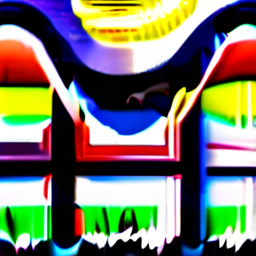

In [13]:
# Initialize model and generate image
config = OptimizationConfig(image_size=(256, 256))
optimized_sdxl = OptimizedSDXL(config=config)

# Generate an image
landscape_prompt = "A picturesque mountain range with a tranquil river flowing through it"
generate_landscape_image(optimized_sdxl, prompt=landscape_prompt)

In [ ]:
# 1. First, fix the generate_landscape_image function definition
def generate_landscape_image(
    model: OptimizedSDXL,
    prompt: str,
    negative_prompt: Optional[str] = None,
    num_inference_steps: int = 50,
    processor: Optional[PromptProcessor] = None  # Add processor parameter
) -> Optional[Image.Image]:
    """Generate landscape image with prompt processing and memory optimization."""
    try:
        # Process prompt if processor provided
        parameters = {}
        if processor:
            parameters = processor.process_prompt(prompt)
            
        print(f"Generating image for prompt: '{prompt}'...")
        
        # Clear memory
        torch.cuda.empty_cache()
        gc.collect()
        
        # Generate with parameters
        image = model.generate_image(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            **parameters
        )
        
        return image
        
    except Exception as e:
        print(f"Error generating image: {e}")
        return None

In [ ]:

if __name__ == "__main__":
    # Initialize processor and model
    processor = PromptProcessor()
    config = OptimizationConfig(image_size=(512, 512))
    model = OptimizedSDXL(config=config)

    # Generate image with processed prompt
    prompt = "A large mountain landscape with dramatic sunset lighting"
    image = generate_landscape_image(
        model=model,
        prompt=prompt,
        negative_prompt="blur, distortion, low quality",
        num_inference_steps=50,
        processor=processor  # Pass processor as a named argument
    )

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating landscape image for prompt: 'A majestic mountain landscape with snow-capped peaks and a crystal clear lake reflecting the sky'...


  0%|          | 0/50 [00:00<?, ?it/s]

Landscape image saved at landscape_image.png.
Generating landscape image for prompt: 'Dense forest with morning mist, rays of sunlight piercing through ancient trees'...


  0%|          | 0/50 [00:00<?, ?it/s]

Landscape image saved at landscape_image.png.
Generating landscape image for prompt: 'Serene coastal scene with gentle waves lapping at a sandy beach, pastel sunset colors'...


  0%|          | 0/50 [00:00<?, ?it/s]

Landscape image saved at landscape_image.png.
